<a href="https://colab.research.google.com/github/RileyWClarke/MLTSA_RClarke/blob/master/HW8/mltsa_hw8_rclarke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLTSA - HW8 - Riley Clarke

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My\ Drive/MLTSA2020/

/content/gdrive/My Drive/MLTSA2020


In [3]:
!wget https://losc.ligo.org/s/events/LOSC_Event_tutorial.zip

--2020-04-24 18:36:54--  https://losc.ligo.org/s/events/LOSC_Event_tutorial.zip
Resolving losc.ligo.org (losc.ligo.org)... 131.215.113.73
Connecting to losc.ligo.org (losc.ligo.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gw-openscience.org/s/events/LOSC_Event_tutorial.zip [following]
--2020-04-24 18:36:54--  https://www.gw-openscience.org/s/events/LOSC_Event_tutorial.zip
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17430588 (17M) [application/zip]
Saving to: ‘LOSC_Event_tutorial.zip’

LOSC_Event_tutorial 100%[===================>]  16.62M  16.6MB/s    in 1.0s    

2020-04-24 18:36:55 (16.6 MB/s) - ‘LOSC_Event_tutorial.zip’ saved [17430588/17430588]



In [4]:
!unzip LOSC_Event_tutorial

Archive:  LOSC_Event_tutorial.zip
   creating: LOSC_Event_tutorial/
   creating: LOSC_Event_tutorial/.ipynb_checkpoints/
  inflating: LOSC_Event_tutorial/.ipynb_checkpoints/LOSC_Event_tutorial-checkpoint.ipynb  
  inflating: LOSC_Event_tutorial/BBH_events_v3.json  
  inflating: LOSC_Event_tutorial/GW150914_4_template.hdf5  
  inflating: LOSC_Event_tutorial/GW151226_4_template.hdf5  
  inflating: LOSC_Event_tutorial/GW170104_4_template.hdf5  
  inflating: LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5  
  inflating: LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5  
  inflating: LOSC_Event_tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5  
  inflating: LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5  
  inflating: LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5  
  inflating: LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5  
  inflating: LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5  
  inflating: LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5  
  

In [5]:
!pip install h5py

In [0]:
#-- SET ME   Tutorial should work with most binary black hole events
#-- Default is no event selection; you MUST select one to proceed.
eventname = ''
eventname = 'GW150914' 
eventname1 = 'GW151226' 
eventname2 = 'LVT151012'
eventname3 = 'GW170104'

# want plots?
make_plots = 1
plottype = "png"
#plottype = "pdf"

In [0]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
LIGOpath = 'LOSC_Event_tutorial'
import sys
sys.path.insert(0, LIGOpath)
import readligo as rl

In [0]:
# Read the event properties from a local json file
fnjson = LIGOpath + "/BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()

In [0]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
tevent = event['tevent']            # Set approximate event GPS time

In [19]:
event

{'a1': 0.355,
 'a2': -0.769,
 'approx': 'lalsim.SEOBNRv2',
 'f_min': 10.0,
 'fband': [43.0, 300.0],
 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5',
 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5',
 'fn_template': 'GW150914_4_template.hdf5',
 'fs': 4096,
 'm1': 41.743,
 'm2': 29.237,
 'name': 'GW150914',
 'tevent': 1126259462.44,
 'utcevent': '2015-09-14T09:50:45.44'}

In [0]:
fs = event['fs']                    # Set sampling rate
fband = event['fband']              # frequency band for bandpassing signal

In [11]:
print("Reading in parameters for event " + event["name"])
print(event)

Reading in parameters for event GW150914
{'name': 'GW150914', 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5', 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5', 'fn_template': 'GW150914_4_template.hdf5', 'fs': 4096, 'tevent': 1126259462.44, 'utcevent': '2015-09-14T09:50:45.44', 'm1': 41.743, 'm2': 29.237, 'a1': 0.355, 'a2': -0.769, 'approx': 'lalsim.SEOBNRv2', 'fband': [43.0, 300.0], 'f_min': 10.0}


In [12]:
#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(LIGOpath + "/" + fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(LIGOpath + "/" + fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()
#strain_H1, time_H1, chan_dict_H1

LOSC_Event_tutorial/readligo.py:138: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  shortnameArray = dqInfo['DQShortnames'].value
LOSC_Event_tutorial/readligo.py:144: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  injnameArray = injInfo['InjShortnames'].value
LOSC_Event_tutorial/readligo.py:149: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  gpsStart = meta['GPSstart'].value


In [13]:
# both H1 and L1 will have the same time vector, so:
time = time_H1

# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))

time_H1: len, min, mean, max =  131072 1126259446.0 1126259461.999878 1126259477.9997559
strain_H1: len, min, mean, max =  131072 -7.044665943156067e-19 5.895522509246437e-23 7.706262192397465e-19
strain_L1: len, min, mean, max =  131072 -1.8697138664279764e-18 -1.0522332249909908e-18 -4.60035111311666e-20
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA


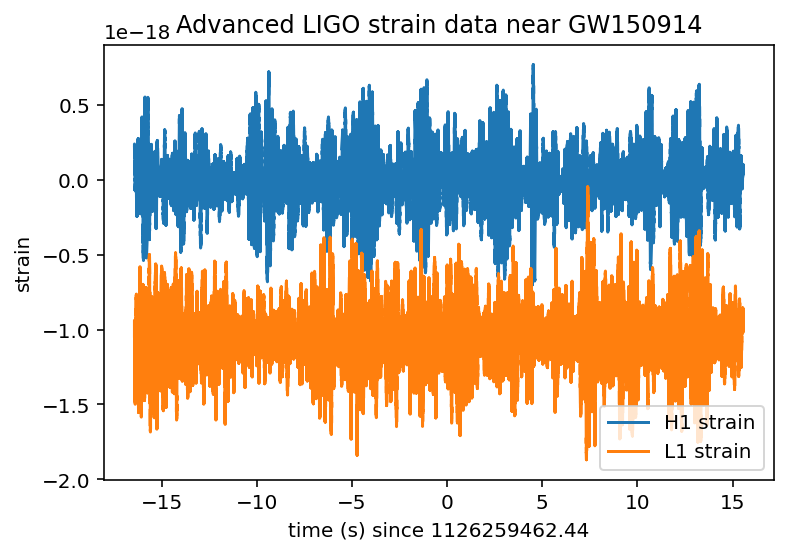

In [14]:
# plot the whole time series :
# index into the strain time series for this time interval:


if make_plots:
    plt.figure()
    plt.plot(time-tevent,strain_H1,label='H1 strain')
    plt.plot(time-tevent,strain_L1,label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_strain.'+plottype)

Figure 1: Full time series of LIGO detection event GW150914, showing both H1 and L1 strain. H1 refers data collected from the LIGO Hanford Observatory in Hanford, WA, and L1 is data collected from the LIGO Livingston Observatory in Livingston, LA. Time is given in GPS time, i.e. number of seconds since Jan 6th, 1980. Strain refers to the spacetime deformation of the LIGO arms caused by gravitation waves, which is detectable by an extremely precise laser interferometer. 

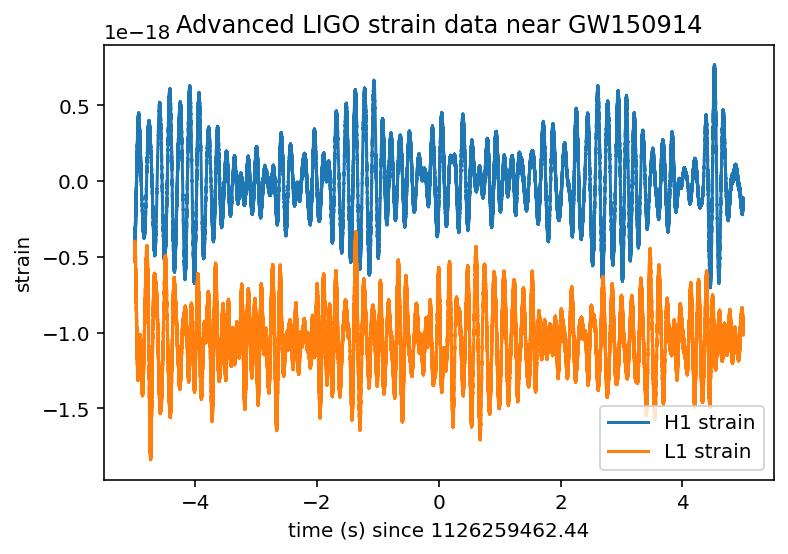

In [15]:
# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

if make_plots:
    plt.figure()
    plt.plot(time[indxt]-tevent,strain_H1[indxt],label='H1 strain')
    plt.plot(time[indxt]-tevent,strain_L1[indxt],label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_strain.'+plottype)

Figure 2: Same time series as in Figure 1, but time axis has been reduced to focus on the event timescale.

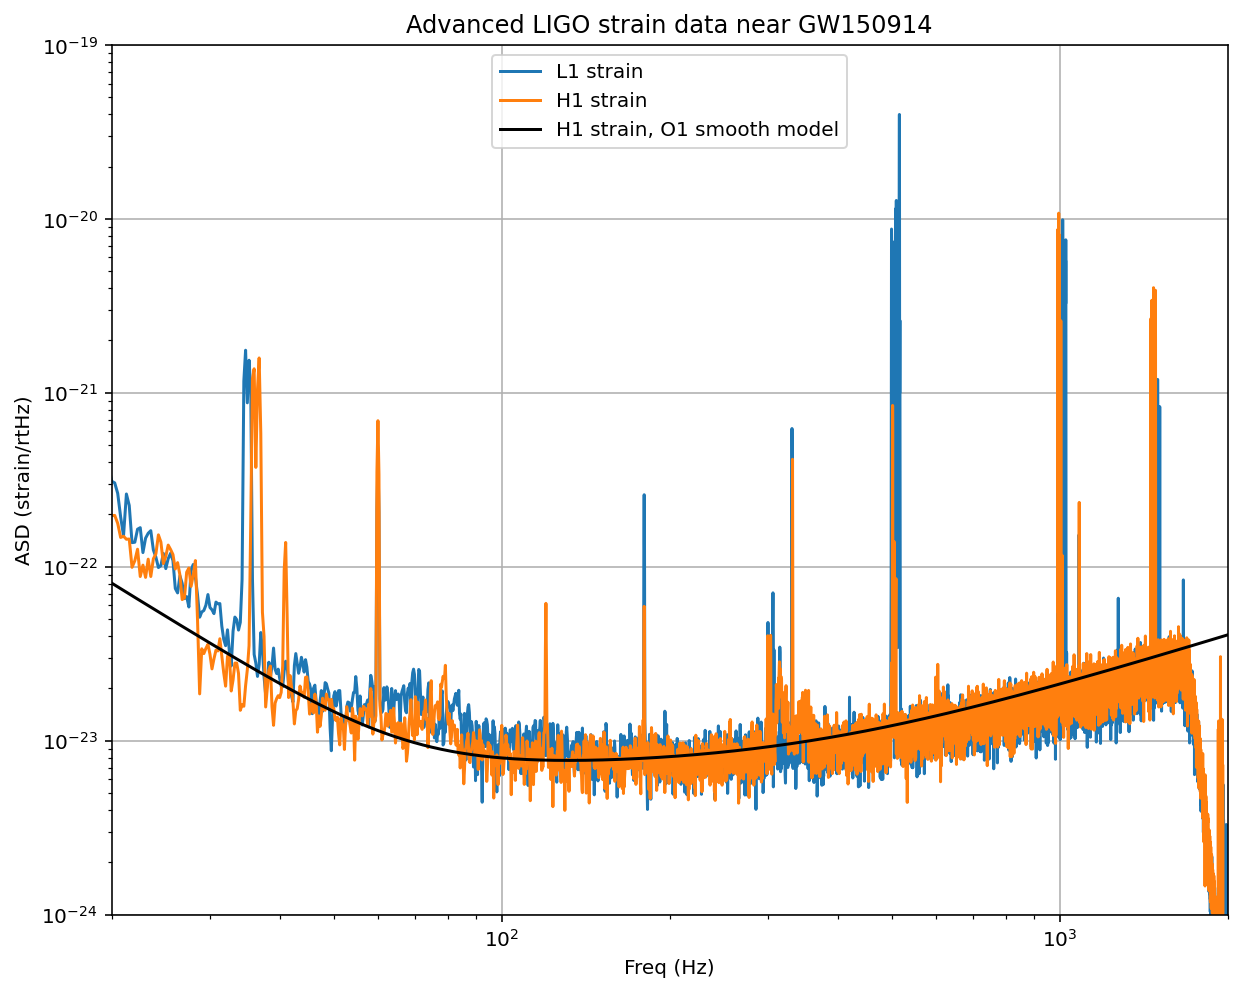

In [16]:
make_psds = 1
if make_psds:
    # number of sample for the fast fourier transform:
    NFFT = 4 * fs
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)

    # Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    psd_smooth = interp1d(freqs, Pxx)

if make_plots:
    # plot the ASDs, with the template overlaid:
    f_min = 20.
    f_max = 2000. 
    plt.figure(figsize=(10,8))
    plt.loglog(freqs, np.sqrt(Pxx_L1),label='L1 strain')
    plt.loglog(freqs, np.sqrt(Pxx_H1),label='H1 strain')
    plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')
    plt.axis([f_min, f_max, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_ASDs.'+plottype)

Figure 3: Amplitude Spectral Density (ASD) of the H1 and L1 time series, which is the square root of the Power Spectral Density (PSD), used to reveal what frequencies exist in the signal, and 'how much' of each frequency is present. The lines in the spectrum are instrumental signals, as instrumental noise dominates the weak GW signal. A smooth PSD for H1 is approximated and laid over the ASD. 

In [0]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    freqs1 = np.linspace(0,2048., int(Nt/2+1))
    

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

whiten_data = 1
if whiten_data:

    # now whiten the data from H1 and L1, and the template (use H1 PSD):
    strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
    strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
    # We need to suppress the high frequency noise (no signal!) with some bandpassing:
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization
    strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten) / normalization
    